In [138]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, plot_confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
trainingData = pd.read_csv('Data/TRAIN_ExtractedFeatures&LABEL.csv')
X = trainingData.loc[:, trainingData.columns != 'LABEL']
y = trainingData['LABEL']

In [158]:
#CALCULO DE MEDIA DE LAS METRICAS SOBRE TODAS LAS PARTICIONES CROSS VALIDATION

cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
scoring = {"recall": "recall","precision":"precision", "f4": make_scorer(fbeta_score,beta=4)}

#NORMAL TRAINING
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=250)) 

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.45714285714285713 +- 0.200318623748288
Precision:
Test: 0.95 +- 0.09999999999999999
Puntuación f4:
 Test: 0.4691755691931873 +- 0.20208718927360006


In [162]:
#TRAINING WITH SMOTE
model = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=250)) 
over = SMOTE(sampling_strategy=1,random_state=10)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.7321428571428571 +- 0.11736911946539273
Precision:
Test: 0.39677871148459387 +- 0.07255064186023556
Puntuación f4:
 Test: 0.6964756254745131 +- 0.11072073067898314


In [154]:
#TRAINING WITH UNDERSAMPLING + SMOTE USANDO EL VALOR ANTERIOR
model = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=250)) 
over = SMOTE(sampling_strategy=1,random_state=10)
under = RandomUnderSampler(sampling_strategy=0.01,random_state=10)
steps = [('under', under), ('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.7321428571428571 +- 0.11736911946539273
Precision:
Test: 0.37326007326007327 +- 0.06382882420500574
Puntuación f4:
 Test: 0.6924856070976849 +- 0.11059509286645947


In [262]:
#USE CROSS VALIDATION TO FIND BEST C
model = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=250)) 
over = SMOTE(sampling_strategy=1,random_state=10)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
scoring = {"recall": "recall","precision":"precision", "f4": make_scorer(fbeta_score,beta=4)}
grid = GridSearchCV(pipeline, param_grid={'model__logisticregression__C':np.linspace(1,5,5)}, 
                    cv = cv, scoring=scoring,return_train_score=True,refit='f4')

fitted = grid.fit(X,y)

pd.DataFrame(grid.cv_results_)[['mean_test_recall', 'std_test_recall', 'mean_test_precision', 'std_test_precision',
                                'mean_test_f4', 'std_test_f4','params']]

,mean_test_recall,std_test_recall,mean_test_precision,std_test_precision,mean_test_f4,std_test_f4,params
0,0.732143,0.117369,0.396779,0.072551,0.696476,0.110721,{'model__logisticregression__C': 1.0}
1,0.732143,0.117369,0.481061,0.109731,0.708535,0.113043,{'model__logisticregression__C': 2.0}
2,0.732143,0.117369,0.555000,0.136382,0.716346,0.114735,{'model__logisticregression__C': 3.0}
3,0.760714,0.155511,0.567987,0.133200,0.743633,0.148881,{'model__logisticregression__C': 4.0}
4,0.735714,0.182946,0.557273,0.130306,0.719374,0.173999,{'model__logisticregression__C': 5.0}


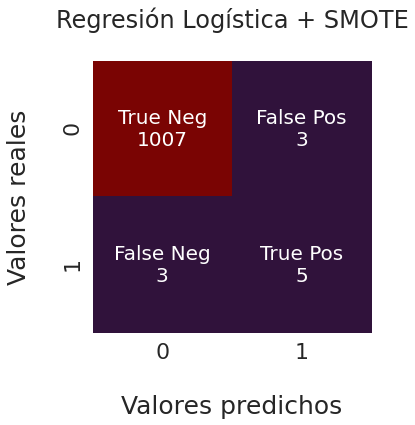

In [307]:
#CONFUSION MATRIX IN TRAINING (en una iteración de la validacion cruzada)

model = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=250,C=4)) 
over = SMOTE(sampling_strategy=1,random_state=10)
steps = [('over', over), ('model', model)]
clf = Pipeline(steps=steps)
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)

for train_index, test_index in cv.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    clf.fit(X_train,y_train)
    y_test = y.iloc[test_index].array
    y_pred = clf.predict(X.iloc[test_index])
    break
    

matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('Regresión Logística + SMOTE\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Training/CM_LR.png', dpi=1000, bbox_inches="tight")

In [263]:
clf = fitted.best_estimator_
scores = cross_validate(clf, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.7607142857142857 +- 0.15551100755055172
Precision:
Test: 0.567987012987013 +- 0.13319978413207675
Puntuación f4:
 Test: 0.7436333166264011 +- 0.1488808932489721


In [301]:
#PRUEBA EN EL CONJUNTO DE TEST
testData = pd.read_csv('Data/TEST_ExtractedFeatures&LABEL.csv')
X_test = testData.loc[:, testData.columns != 'LABEL']
y_test = testData['LABEL']
from sklearn.metrics import precision_recall_curve, auc

clf = fitted.best_estimator_
y_pred = clf.predict(X_test)
print('precision:',precision_score(y_test, y_pred, average='binary')) # TP / (TP + FP)
print('recall:',recall_score(y_test, y_pred, average='binary')) # TP / (TP + FN)
print('f4:',fbeta_score(y_test, y_pred, beta=4, average="binary"))
precision, recall, _  = precision_recall_curve(y_test, clf.decision_function(X_test))
print('PR AUC:',auc(recall, precision))

precision: 0.3333333333333333
recall: 0.6
f4: 0.5730337078651685
PR AUC: 0.6040361948437284


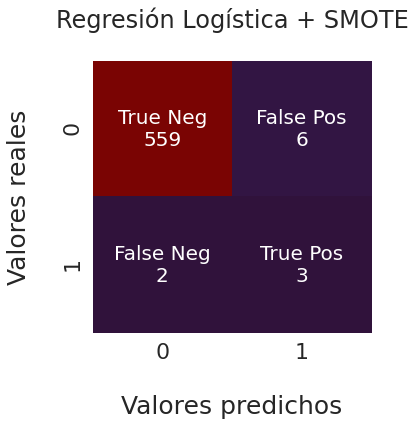

In [277]:
#CONFUSION MATRIX
matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('Regresión Logística + SMOTE\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Test/CM_LR.png', dpi=1000, bbox_inches="tight")